# Optical Flow using Lucas Kanade Method
### Assignment 4 
#### Shubh Maheshwari 20161170

In this assignment our goal is to apply optical flow for tracking objects in a moving scene 

The method works by finding movement of pixels in the 2 frames. Here we find the least square solution on a vector using the gradient in the x&y direaction to predicts the movement of the pixels 

We are given the a dataset containg 2 & 8 frames. 


In [2]:
# Imports 
import os
import cv2
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt 
    
%matplotlib inline

In [48]:
# Helper functions 
def display_animation(frame_list):
    pass

def display_images(img_list, shape,fig_size=(8,8),tile=None,is_gray=None):
    """
        Display multple images using matplotlib
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    if is_gray is None:
        is_gray = np.zeros(shape)
    
    m,n = shape
    fig = plt.figure(figsize=fig_size)
    
    for i in range(m):
        for j in range(n):
            ax = fig.add_subplot(m,n,i*n + j+1)
            if is_gray[i,j] == 1:
                ax.imshow(img_list[i][j],cmap='gray')
            else:
                img_list[i][j] = cv2.resize(img_list[i][j],(200,200))
                ax.imshow(img_list[i][j])   
            ax.axis('off')
    plt.show()
    return 

def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):
    """
        Display results of optical flow
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    fig = plt.figure(figsize=fig_size)
    
    #     Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Optical flow Arrows")
    
#     arrow_ind_y,arrow_ind_x = np.where(u*u + v*v > arrow_thres)
    kp = cv2.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))
        
    ax = fig.add_subplot(1,2,2)
    ax.imshow( (u*u + v*v>arrow_thres),cmap='gray')
    ax.set_title("Optical flow Mask")
    
    ax.axis('off')
   

    plt.show()
    
    return None
# 2d Convolution
def conv2d(a, f,pad=True):
    """
        Run 2d Convolution on a Matrix using the filter f
        @param a:=> 2d Matrix
        @param f:=> filter (list or numpy array)
        
        return convolved matrix  
    """
    f = np.array(f)
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape = s, strides = a.strides * 2)
    return np.einsum('ij,ijkl->kl', f, subM)

### Here we have defined our optical flow method
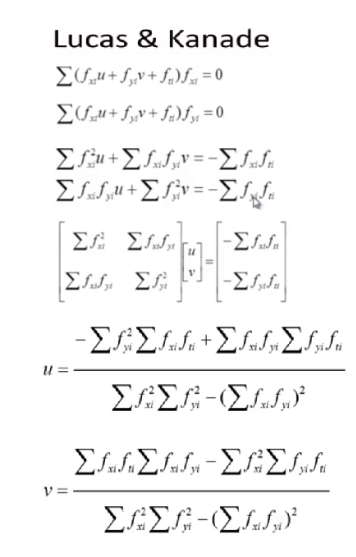

In [4]:
def optical_flow(I1g, I2g, window_size, tau=1e-2):
#     Define our kernels to calculate gradients
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = window_size//2 # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g / 255. # normalize pixels
    I2g = I2g / 255. # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t by conv2d
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode='same')
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode='same')
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode='same') + \
        signal.convolve2d(I1g, -kernel_t, boundary='symm', mode='same')
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    
    # For each window calculate the vectors [u,v]    
    # within windw window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            
            A = [ [ np.sum(Ix*Ix),np.sum(Ix*Iy)], [np.sum(Iy*Ix), np.sum(Iy*Iy)] ]
            A = np.array(A)
    
            b = [-np.sum(Ix*It), -np.sum(Iy*It)]
            b = np.array(b)
            
            # if threshold τ is larger than the smallest eigenvalue of A'A:
            U,D,V_T = np.linalg.svd(A.T.dot(A))
            if np.min(D) < tau:
                u[i,j]=0
                v[i,j]=0                
            
            else:
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
                
    return [u,v]

In [5]:
img_dir ='./eval-gray-twoframes/eval-data-gray/'

img_pair_list = []
img_pair_list = []
for dirname in os.listdir(img_dir):
    if os.path.isdir(os.path.join(img_dir,dirname)):
        im1_path,im2_path = os.listdir(os.path.join(img_dir,dirname))

        im1 = cv2.imread(os.path.join(img_dir,dirname,im1_path),0)
        im2 = cv2.imread(os.path.join(img_dir,dirname,im2_path),0)
        img_pair_list.append([im1,im2])
    else:
        print("File if not a dir",dirname)

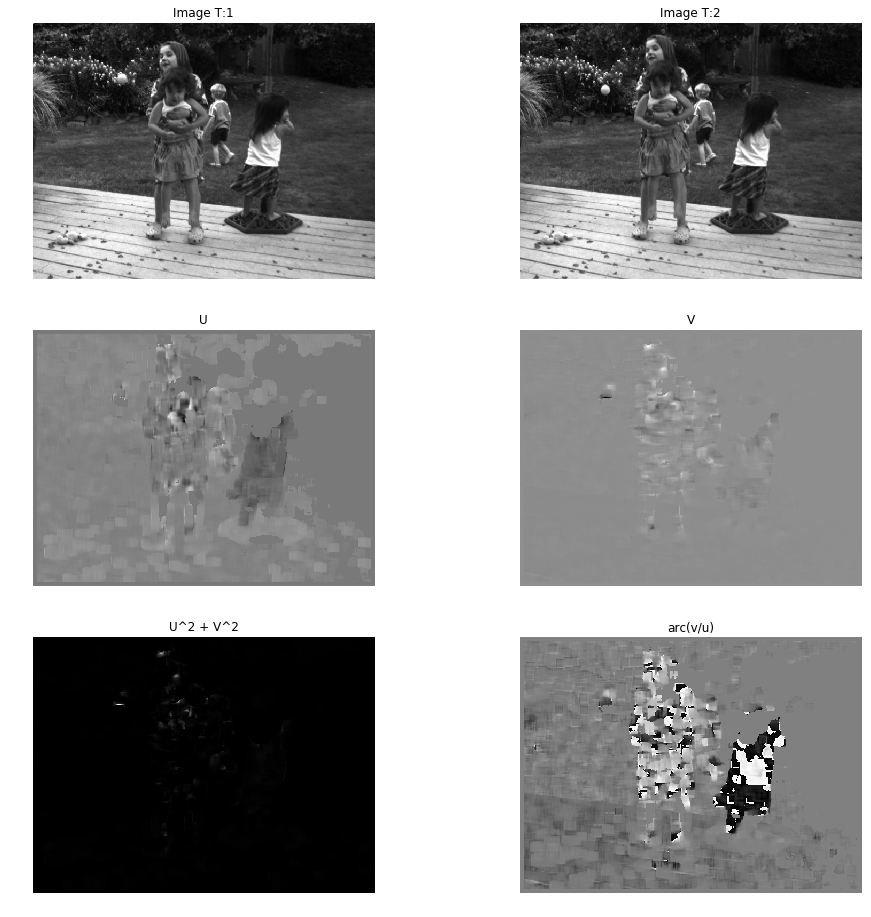

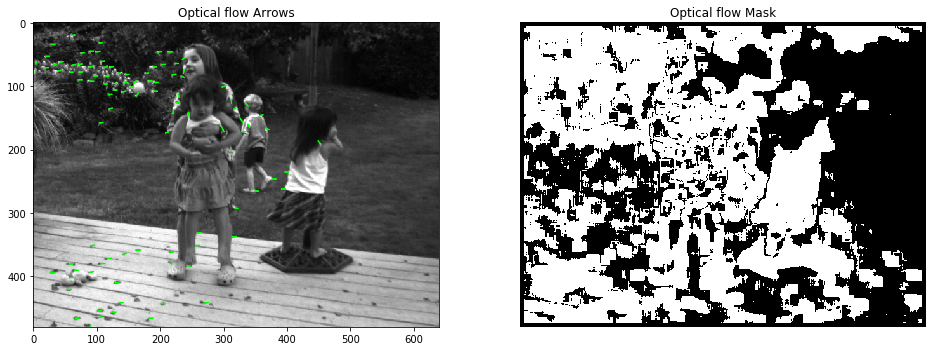

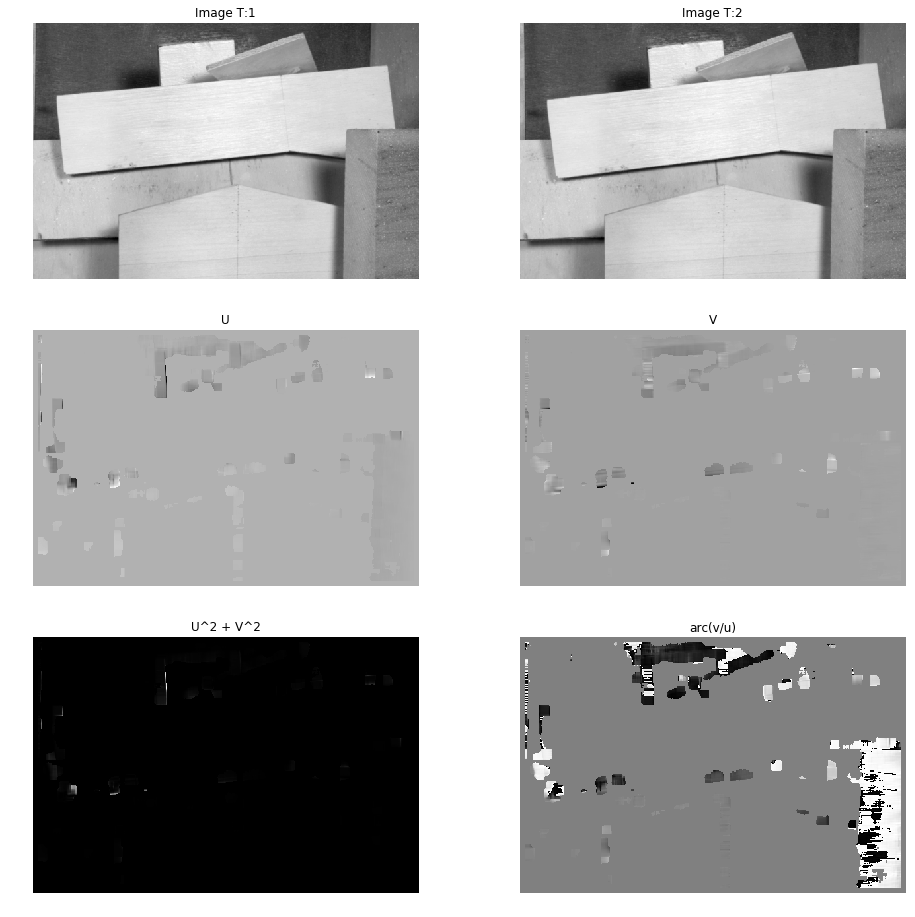

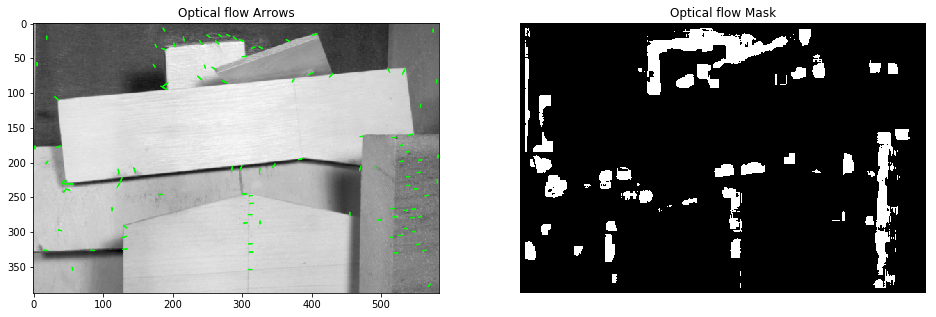

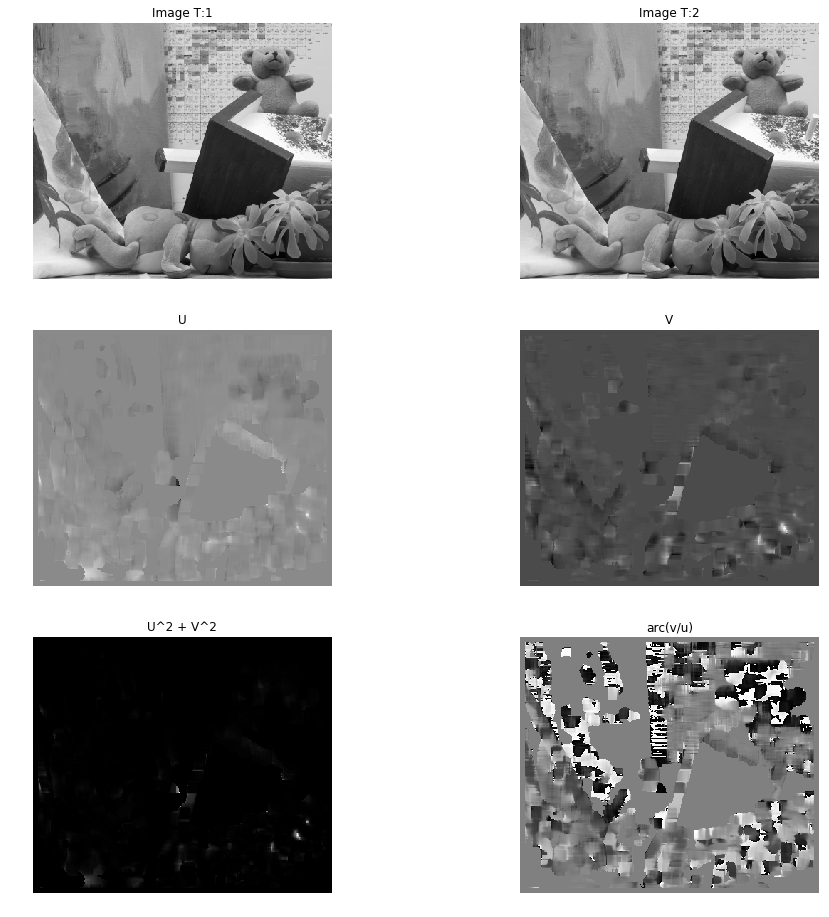

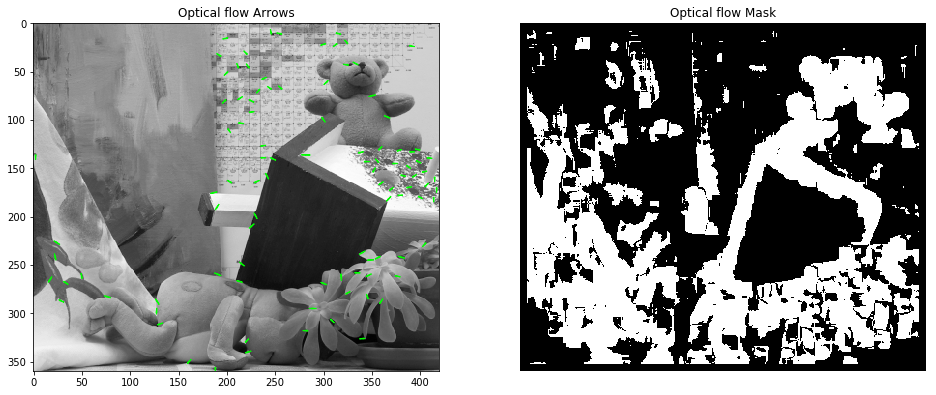

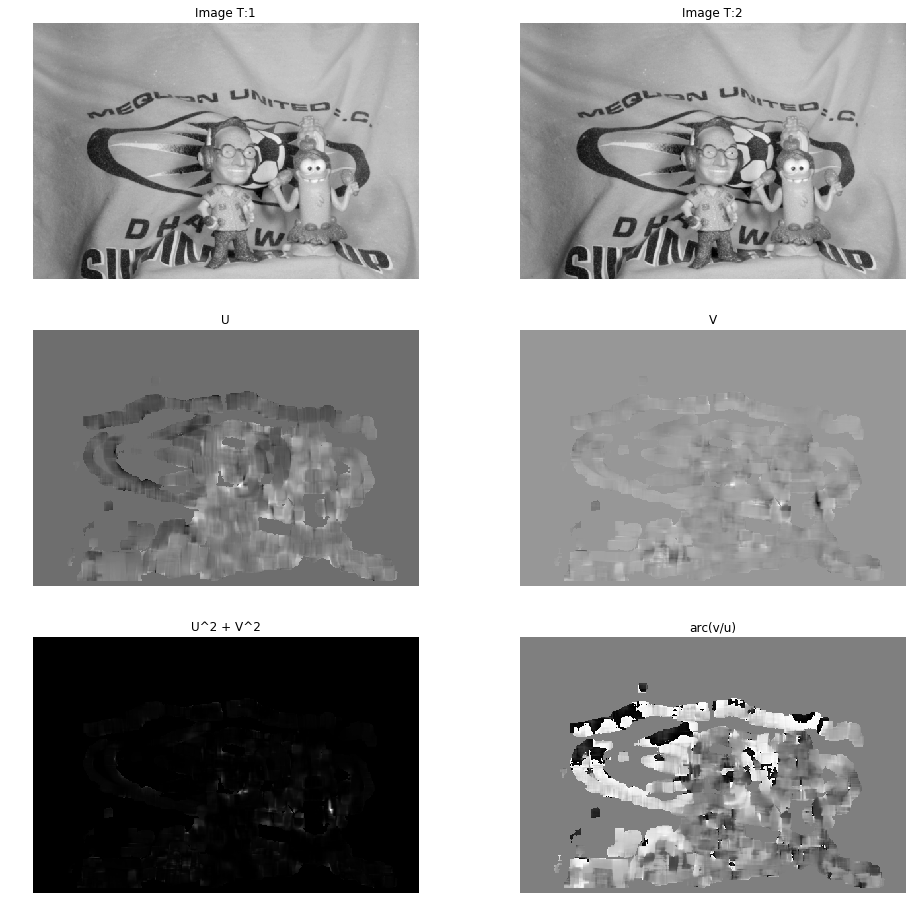

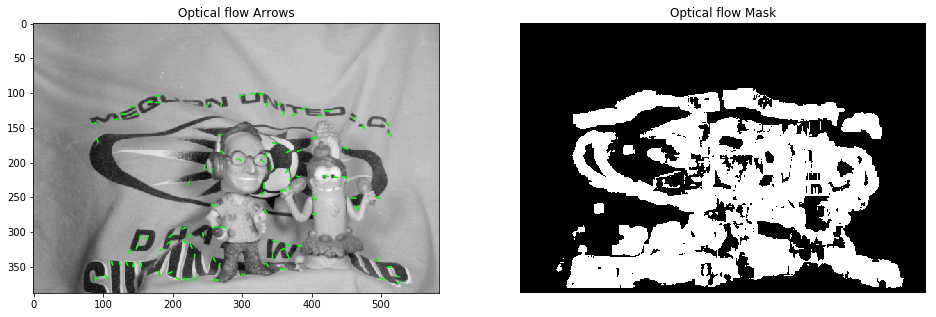

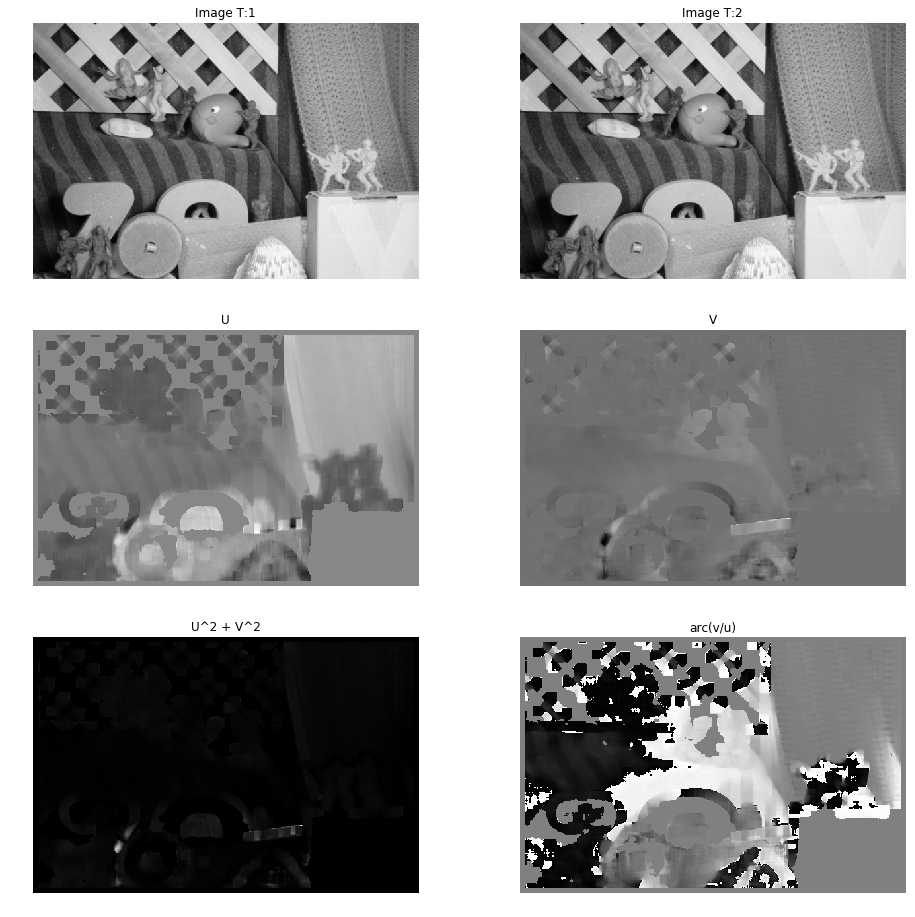

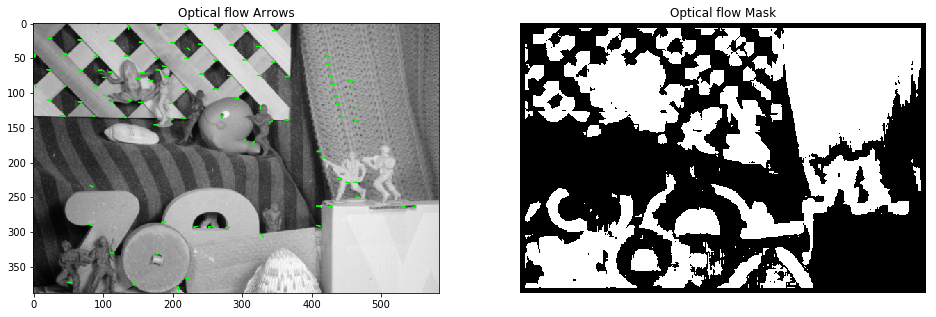

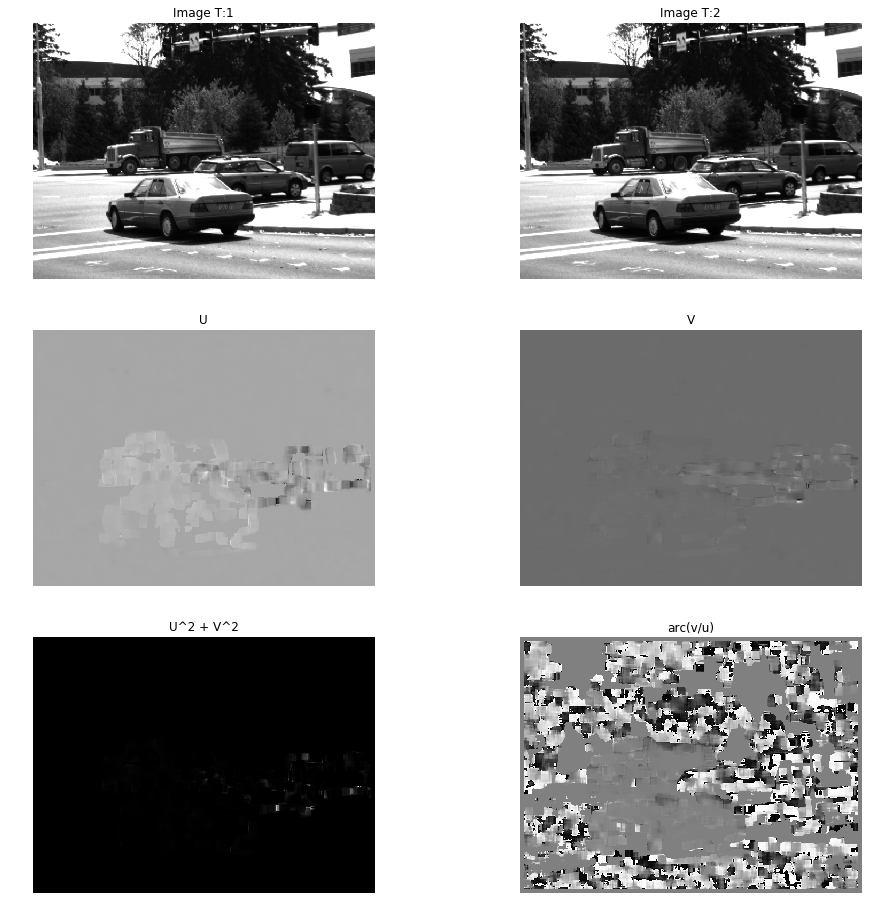

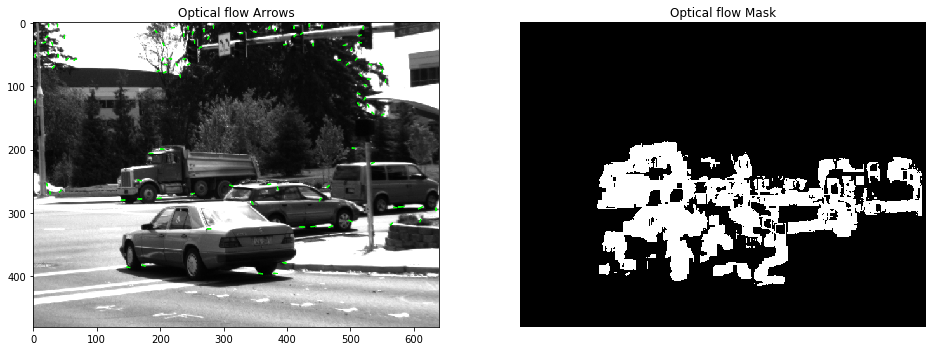

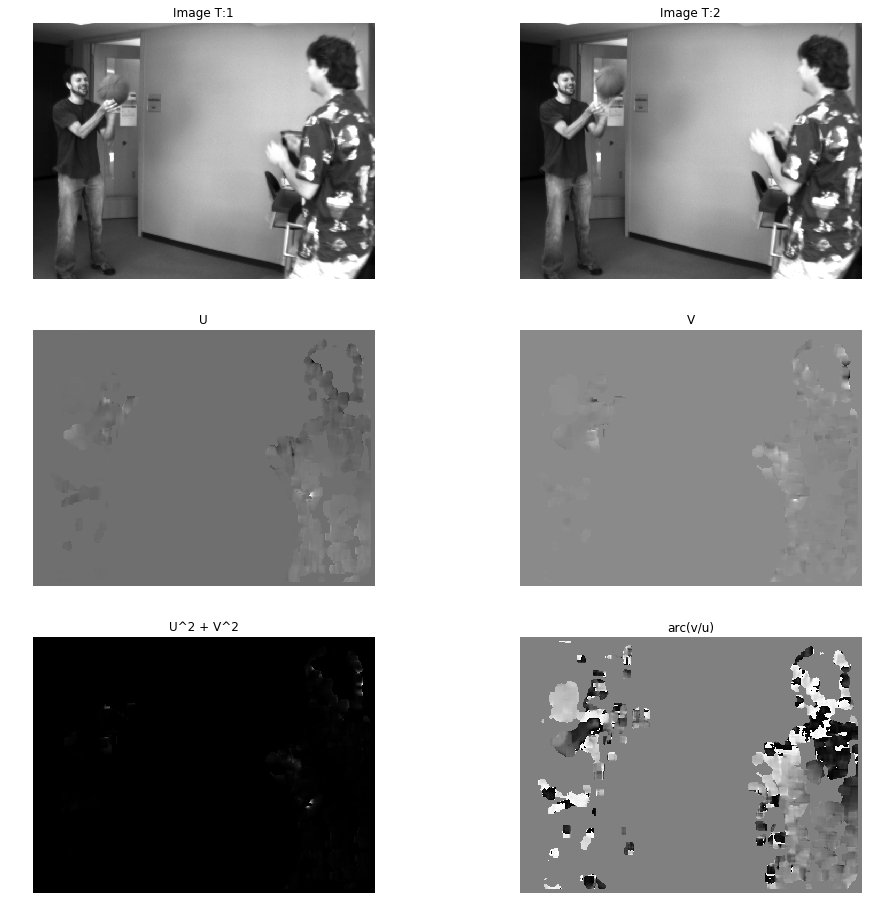

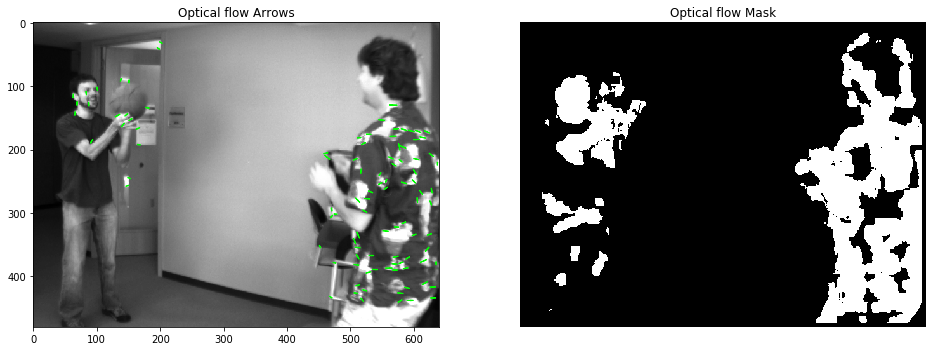

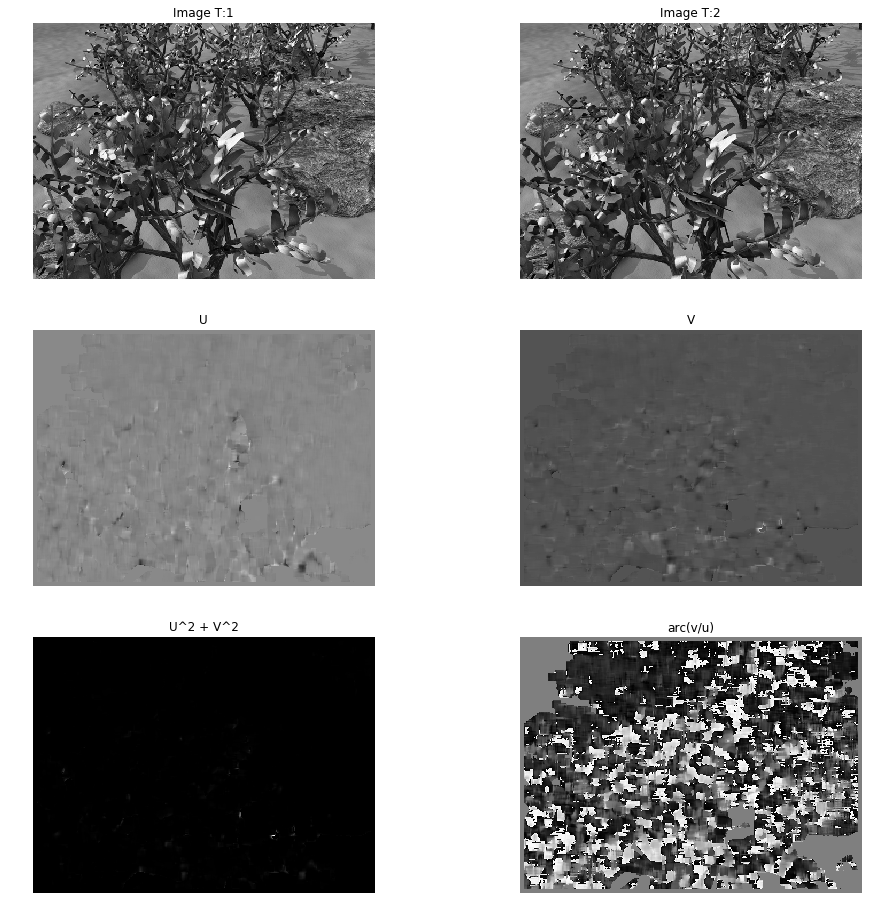

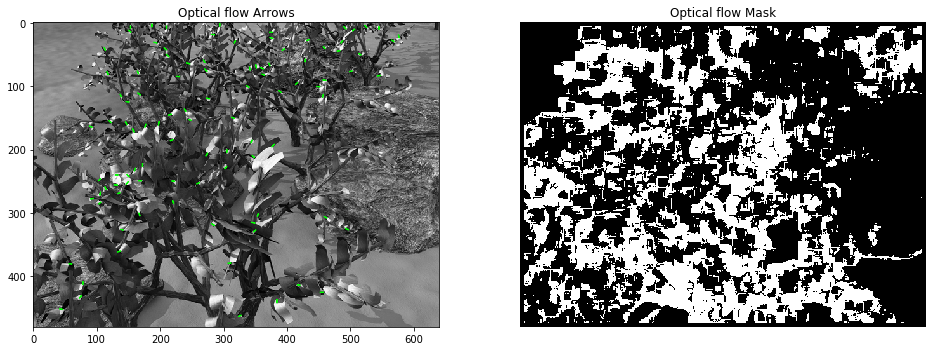

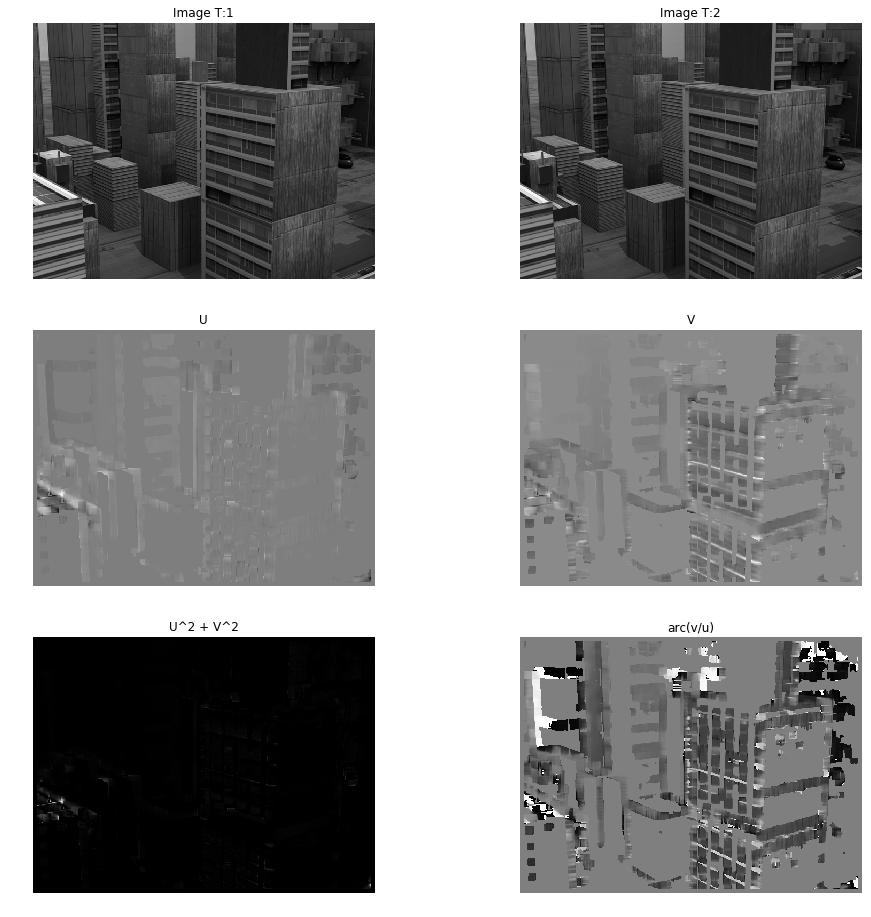

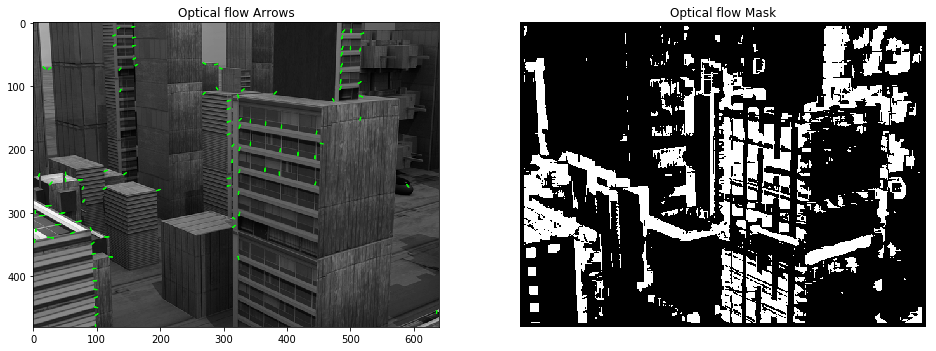

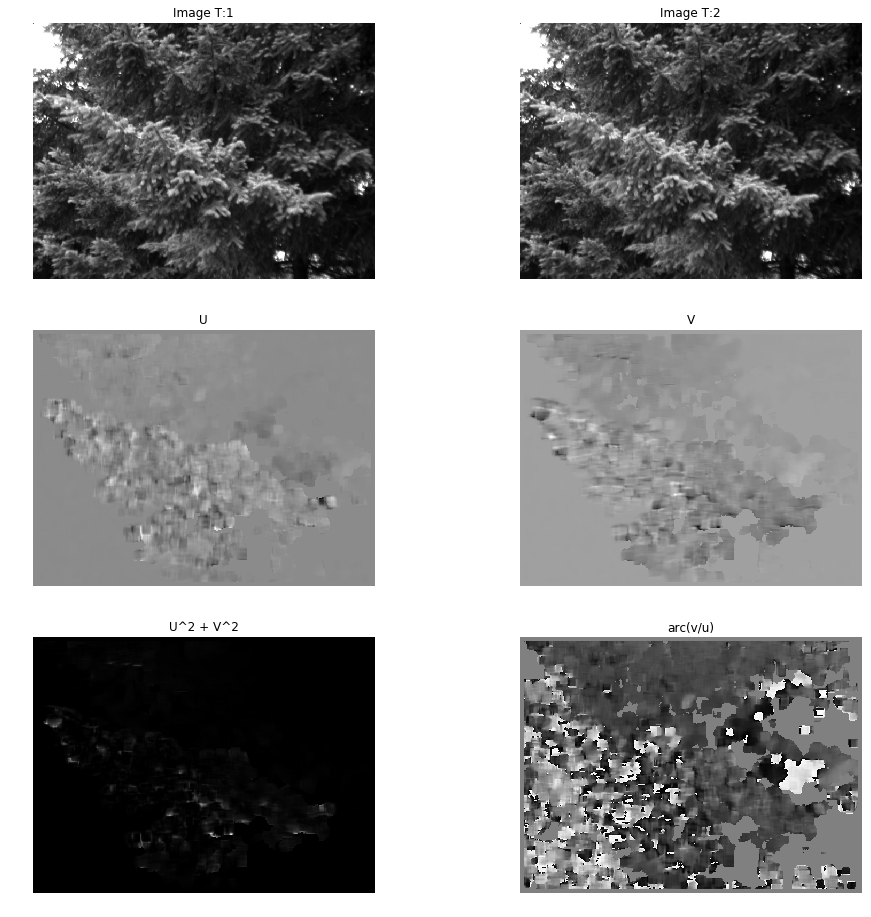

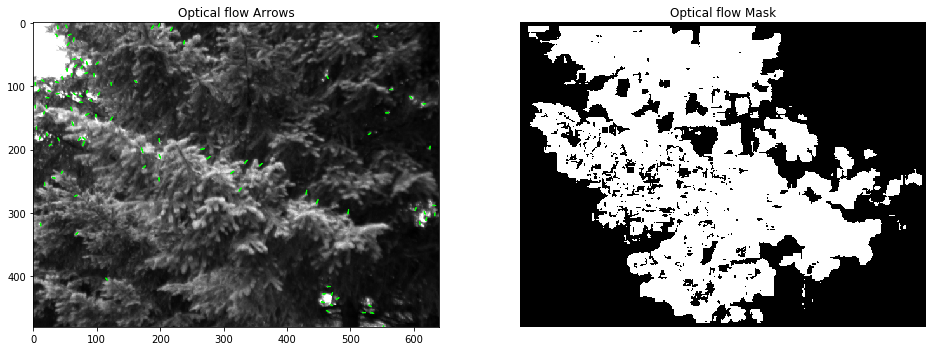

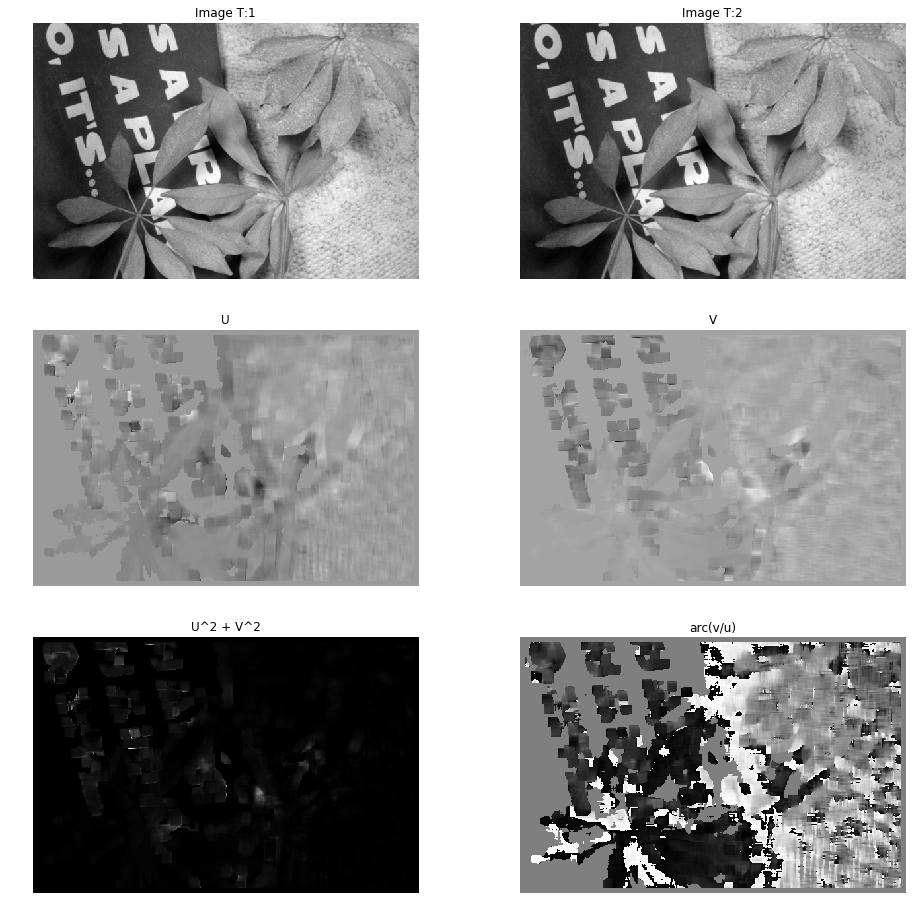

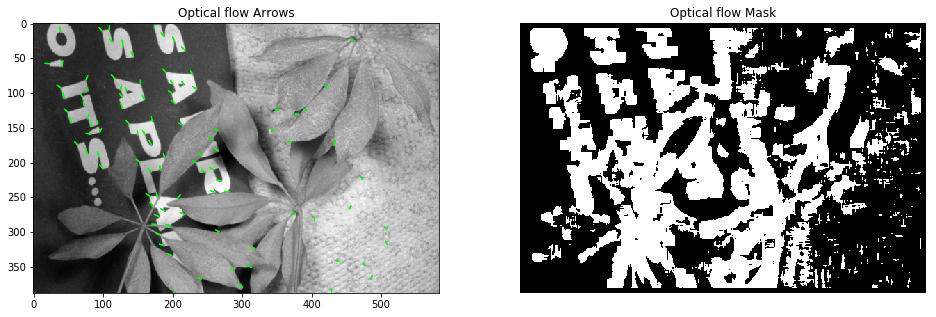

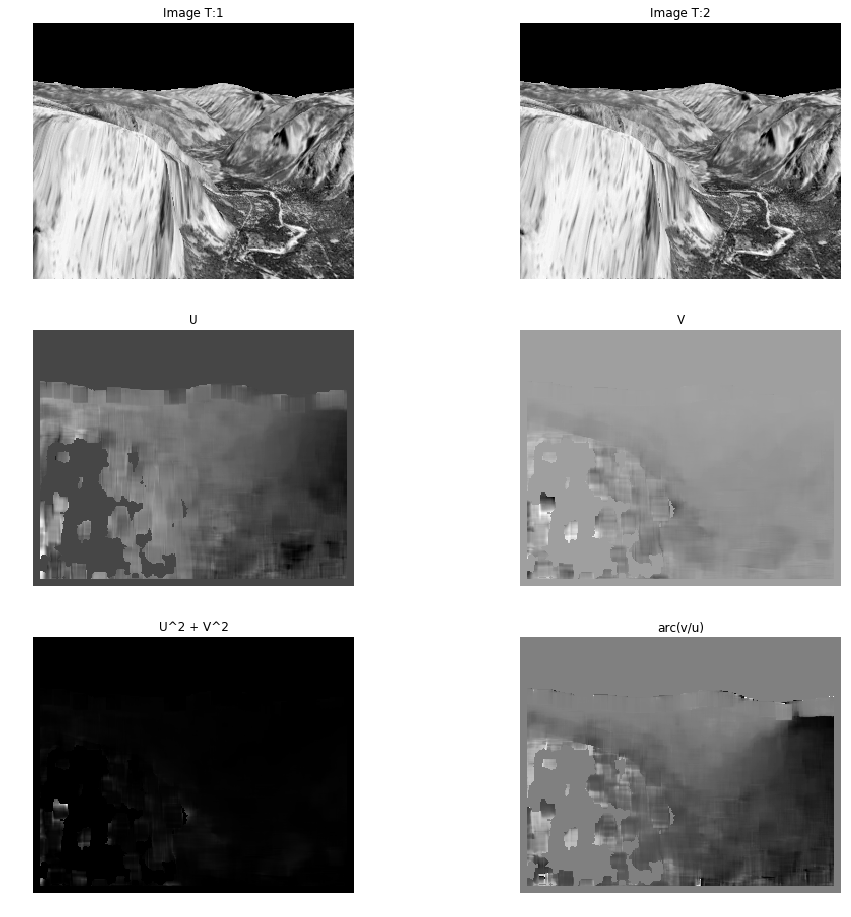

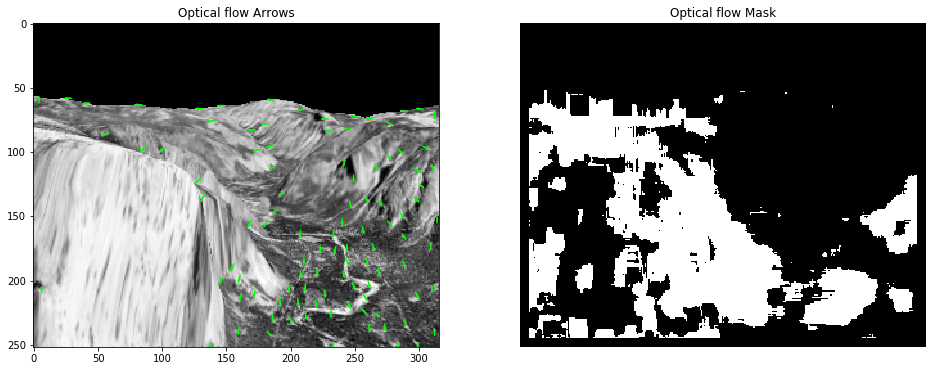

In [52]:
# Calculate optical flow on images
cnt = 0
for image_pair in img_pair_list:
    cnt +=1 
    im1,im2 = image_pair
    u,v = optical_flow(im1,im2,window_size=15)
    display_opticalflow_results(im1,im2,u,v,arrow_thres=1)

#### We can notice in cases where the camera is moving almost the scene gets segmented out.
#### Whereas when the object moves only the object gets segmented out 